<a href="https://colab.research.google.com/github/ahsanabbas123/tensorflow-specialization/blob/master/Happy_Sad_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import os
import zipfile


DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()


--2019-08-15 10:48:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2019-08-15 10:48:06 (182 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



## Loading Images

In [0]:
main_dir = os.path.join('/tmp/h-or-s')

In [0]:
os.listdir(main_dir)

['sad', 'happy']

In [0]:
happy_images = os.path.join('/tmp/h-or-s/happy')
sad_images = os.path.join('/tmp/h-or-s/sad')

In [0]:
# Paths
happylabels = os.listdir(happy_images)
sadlabels = os.listdir(sad_images)

In [0]:
# Example Labels
print (happylabels[:10])
print (sadlabels[:10])

['happy1-13.png', 'happy1-19.png', 'happy1-10.png', 'happy2-18.png', 'happy2-05.png', 'happy1-11.png', 'happy2-17.png', 'happy2-12.png', 'happy2-06.png', 'happy2-03.png']
['sad1-03.png', 'sad2-13.png', 'sad1-12.png', 'sad1-00.png', 'sad1-01.png', 'sad1-19.png', 'sad1-10.png', 'sad1-13.png', 'sad2-11.png', 'sad2-15.png']


In [0]:
# Total images
print ("Total Happy:",len(happylabels))
print ("Total Sad:",len(sadlabels))
print ("Total Images:", len(happylabels) + len(sadlabels))


Total Happy: 40
Total Sad: 40
Total Images: 80


In [0]:
# Checking Shape of Image
pic = os.path.join(happy_images, happylabels[1])
import cv2
im = cv2.imread(pic)
im.shape

(150, 150, 3)

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

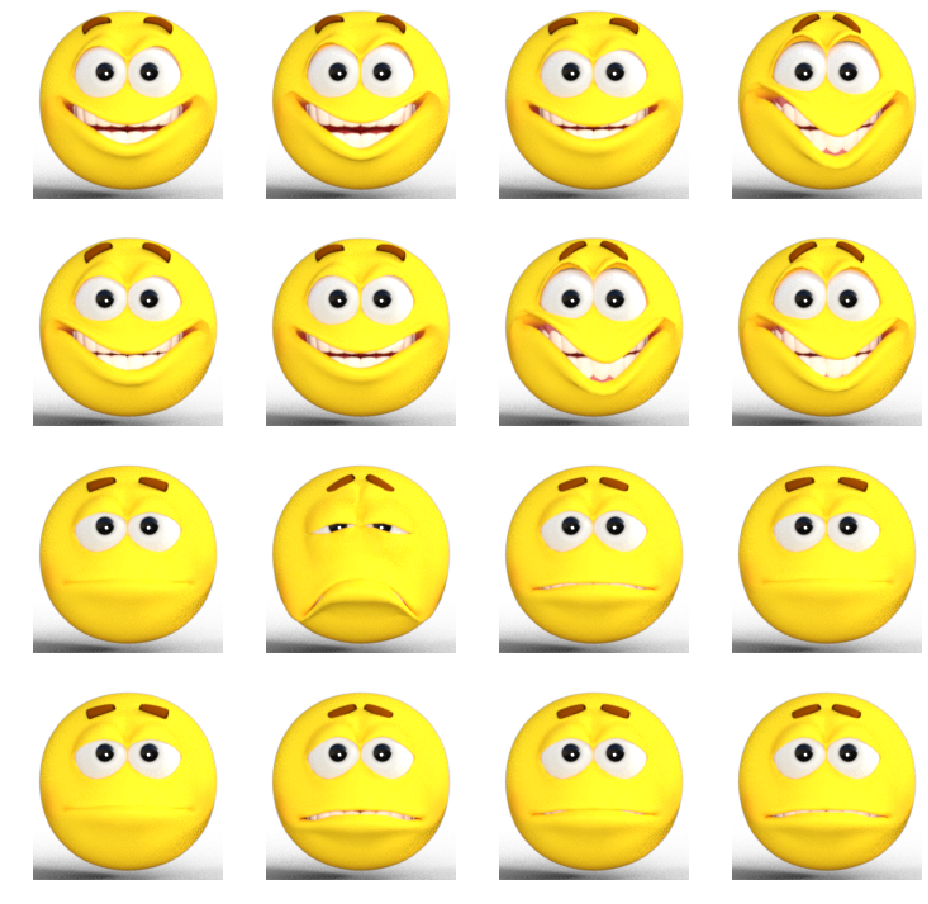

In [0]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(happy_images, fname) 
                for fname in happylabels[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(sad_images, fname) 
                for fname in sadlabels[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building Model

In [0]:
# Define and Compile the Model
model = tf.keras.models.Sequential([
                                    
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Conv2D(16, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(lr = 0.001), loss = 'binary_crossentropy', metrics = ['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 16)       

## Data Preprocessing

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
                        '/tmp/h-or-s',
                        target_size = (150, 150),
                        batch_size = 8,
                        class_mode = 'binary'                   
)

Found 80 images belonging to 2 classes.


In [0]:
train_generator

## Fitting Model

In [0]:
class myCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = {}):
       if logs.get('acc') > 0.999:
         print ("\nStopping as accuracy > 99.9%")
         self.model.stop_training = True 

callbacks = myCallback()

In [0]:
shistory = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      callbacks = [callbacks])


Epoch 1/15
8/8 [==============================] - 1s 132ms/step - loss: 2.3291 - acc: 0.4219
Epoch 2/15
8/8 [==============================] - 0s 24ms/step - loss: 0.6849 - acc: 0.4844
Epoch 3/15
8/8 [==============================] - 0s 21ms/step - loss: 0.6642 - acc: 0.6406
Epoch 4/15
8/8 [==============================] - 0s 21ms/step - loss: 0.4521 - acc: 0.8438
Epoch 5/15
8/8 [==============================] - 0s 16ms/step - loss: 0.3593 - acc: 0.8906
Epoch 6/15
8/8 [==============================] - 0s 19ms/step - loss: 0.1607 - acc: 0.9531
Epoch 7/15
8/8 [==============================] - 0s 21ms/step - loss: 0.3680 - acc: 0.8906
Epoch 8/15
8/8 [==============================] - 0s 23ms/step - loss: 0.2177 - acc: 0.9375
Epoch 9/15
8/8 [==============================] - 0s 20ms/step - loss: 0.2305 - acc: 0.8906
Epoch 10/15
8/8 [==============================] - 0s 17ms/step - loss: 0.1161 - acc: 0.9531
Epoch 11/15
8/8 [==============================] - 0s 19ms/step - loss: 0.1619